# Thesis Notebook - Sebastian Gsell

This notebook provides the interface to the estimation of Marginal Treatment Effects (MTE) via *grmpy_semipar*. 
First, I replicate the semiparametric results from 

> Carneiro, P., Heckman, J. J., & Vytlacil, E. J. (2011). [Estimating marginal returns to education.](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754) *American Economic Review, 101*(6), 2754-81. 

The authors analyze the returns to college for white males born between 1957 and 1963 using data from the National Longitudinal Survey of Youth 1979. The authors provide some [replication material]((https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754)) on their website but do not include geographic identifiers. Therefore, I make use of a mock data merging background characteristics and local data randomly. 

Below, I'll also present the results of my empirical analysis of the GSOEP. Using the method of Local Instrumental Variables (LIV), I'll show that returns to higher education in Germany vary considerable, as indiviudals select into university based on their unobserved benefits.


In a future update, the semiparametric estimation method will be included in the open-source package *grmpy* for the simulation and estimation of the generalized Roy model in Python. Currently, *grmpy* is limited to the estimation of a parametric normal version of the generalized Roy model. <br> For more, see the [online documentation](https://grmpy.readthedocs.io/en/develop/). 

## 0) Imports

In [1]:
import numpy as np
import warnings

from semipar.estimation.estimate import fit

from thesis_auxiliary import plot_common_support
from thesis_auxiliary import plot_mte_carneiro
from thesis_auxiliary import plot_mte_soep
from thesis_auxiliary import plot_mte_par

warnings.filterwarnings('ignore')

## 1) Local Instrumental Variables

The method of Local Instrumental Variables (LIV) is based on the generalized Roy model, which is characterized by the following equations:

\begin{align*}
 &\textbf{Potential Outcomes} & & \textbf{Choice}  &\\
 & Y_1 = \beta_1 X + U_{1} &  & I = Z \gamma - V &\\
 & Y_0 = \beta_0 X + U_{0} &  & D_i = \left\{
\begin{array}{ll}
1 & if \ I > 0 \\
0 & if \ I \leq 0\\
\end{array}
\right. 
&&&&\\
& \textbf{Observed Outcome} &&&\\
& Y = D Y_1 + (1-D) Y_0 &&&
\end{align*}

We work with the linear-in-the-parameters version of the generalized Roy model:

\begin{align}
E(Y|X = \overline{x}, P(Z) = p) =  \overline{x} \beta_0 + p \overline{x} (\beta_1 - \beta_0) + K(p),
\end{align}


where $K(p) = E(U_1 - U_0 | D = 1, P(Z) = p)$ is a nonlinear function of $p$ that captures heterogeneity along the unobservable resistance to treatment $u_D$. 

In addition, assume that $(X, Z)$ is independent of $\{U_1, U_0, V\}$. Then, the MTE is

1) additively separable in $X$ and $U_D$, which means that the shape of the MTE is independent of $X$, and

2) identified over the common support of $P(Z)$, unconditional on $X$. 


The common support, $P(Z)$, plays a crucial role for the identification of the MTE. 
It denotes the probability of going to university ($D=1$). Common support is defined as the intersection of the support of $P(Z)$ given $D = 1$ and the support of $P(Z)$ given $D = 0$. i.e., those evaluations of $P(Z)$ for which we obtain positive frequencies in both subsamples. We will plot it below. The larger the common support, the larger the region over which the MTE is identified.

The LIV estimator, $\Delta^{LIV}$, is derived as follows (Heckman and Vytlacil [2001](https://www.aeaweb.org/articles?id=10.1257/aer.91.2.107), [2005](https://www.jstor.org/stable/3598865?seq=1#page_scan_tab_contents)):

\begin{equation}
\begin{split}
\Delta^{LIV} (\overline{x}, u_D) &= \frac{\partial E(Y|X = \overline{x}, P(Z) = p)}{\partial p}  \bigg\rvert_{p = u_D} \\
& \\
&= \overline{x}(\beta_1 - \beta_0) + E(U_1 - U_0 | U_D = u_D) \\
&\\
& = \underbrace{\overline{x}(\beta_1 - \beta_0)}_{\substack{observable \\ component}} + \underbrace{\frac{\partial K}{\partial p} \bigg\rvert_{p = u_D}}_{\substack{k(p): \ unobservable \\ component}} = MTE(\overline{x}, u_D)
\end{split}
%\frac{[E(U_1 - U_0 | U_D \leq p] p}{\partial p}  \bigg\rvert_{p = u_D}
%E(U_1 - U_0 | U_D = u_D)
\end{equation}


Since we do not make any assumption about the functional form of the unobservables, we estimate $k(p)$ non-parametrically. In particualr, $k(p)$ is the first derivative of a locally quadratic kernel regression.

## 2) The Initialization File

For the semiparametric estimation, we need information on the following sections:

* __ESTIMATION__: Specify the dependent (wage) and indicator variable (treatment dummy) of the input data frame.
For the estimation of the propensity score $P(Z)$, we choose a probability model, here logit. Furthermore, we select 30 bins to determine the common support in the treated and untreated subsamples. For the locally quadratic regression, we follow the specification of [Carneiro et al. (2011)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754) and choose a bandwidth of 0.322. The other parameters in this section are set by default and, normally, do not need to be adjusted. <br>



* __TREATED, UNTREATED, CHOICE__: In this section, the variables of the outcome equations (treated, untreated) and the college decision (choice) are specified.

* __DIST__: The distribution of the unobservables is not of relevance in the semiparametric apporach and can be ignored.

In [2]:
%%file semipar/files/replication_carneiro.yml
---
ESTIMATION:
    file: semipar/data/aer-replication-mock.pkl
    dependent: wage
    indicator: state
    semipar: True
    show_output: True
    logit: True
    nbins: 30
    trim_support: True
    reestimate_p: False
    rbandwidth: 0.05
    derivative: 1
    degree: 2
    bandwidth: 0.322
    gridsize: 500
    ps_range: [0.005, 0.995]
    truncate: True 
TREATED:
    order:
    - exp
    - expsq
    - lwage5
    - lurate
    - cafqt
    - cafqtsq
    - mhgc
    - mhgcsq
    - numsibs
    - numsibssq
    - urban14
    - lavlocwage17
    - lavlocwage17sq
    - avurate
    - avuratesq
    - d57
    - d58
    - d59
    - d60
    - d61
    - d62
    - d63
UNTREATED:
    order:
    - exp
    - expsq
    - lwage5
    - lurate
    - cafqt
    - cafqtsq
    - mhgc
    - mhgcsq
    - numsibs
    - numsibssq
    - urban14
    - lavlocwage17
    - lavlocwage17sq
    - avurate
    - avuratesq
    - d57
    - d58
    - d59
    - d60
    - d61
    - d62
    - d63
CHOICE:
    params:
    - 1.0
    order:
    - const
    - cafqt
    - cafqtsq
    - mhgc
    - mhgcsq
    - numsibs
    - numsibssq
    - urban14
    - lavlocwage17
    - lavlocwage17sq
    - avurate
    - avuratesq
    - d57
    - d58
    - d59
    - d60
    - d61
    - d62
    - d63
    - lwage5_17numsibs
    - lwage5_17mhgc
    - lwage5_17cafqt
    - lwage5_17
    - lurate_17
    - lurate_17numsibs
    - lurate_17mhgc
    - lurate_17cafqt
    - tuit4c
    - tuit4cnumsibs
    - tuit4cmhgc
    - tuit4ccafqt
    - pub4
    - pub4numsibs
    - pub4mhgc
    - pub4cafqt
DIST:
    params:
    - 0.1
    - 0.0
    - 0.0
    - 0.1
    - 0.0
    - 1.0

Overwriting semipar/files/replication_carneiro.yml


We now proceed to the replication.

## 2) Replication of Carneiro et al. (2011)

Conduct the estimation based on the initialization file.

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Fri, 17 Jan 2020   Pseudo R-squ.:                  0.2858
Time:                        03:12:52   Log-Likelihood:                -864.74
converged:                       True   LL-Null:                       -1210.8
Covariance Type:            nonrobust   LLR p-value:                4.178e-127
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              288.3699    151.012      1.910      0.056      -7.609     584.349
cafqt               -6.4256      5.019     -1.280      0.200     -16.263       3.411
cafqtsq              0.3348 

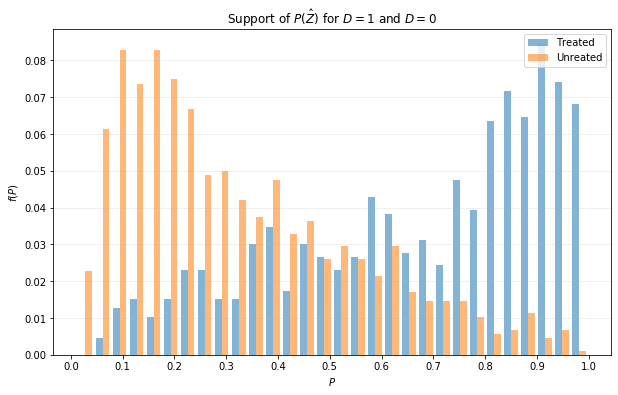

In [3]:
rslt = fit("semipar/files/replication_carneiro.yml", semipar=True)

The rslt dictionary contains information on the estimated parameters and the final MTE. 

In [4]:
list(rslt)

['quantiles', 'mte', 'mte_x', 'mte_u', 'mte_min', 'mte_max', 'X', 'b1-b0']

Before plotting the MTE, let's see what else we can learn.
For instance, we can account for the variation in $X$. <br>
Note that we divide the MTE by 4 to investigate the effect of one additional year of college education.

In [5]:
np.min(rslt['mte_min']) / 4, np.max(rslt['mte_max']) / 4

(-0.5703098725428841, 0.6420576895047017)

Next we plot the MTE based on the estimation results. As shown in the figure below, the replicated MTE gets very close to the original, but its 90 percent confidence bands are wider. This is due to the use of a mock data set which merges basic and local variables randomly. The bootsrap method, which is used to estimate the confidence bands, is sensitive to the discrepancies in the data.

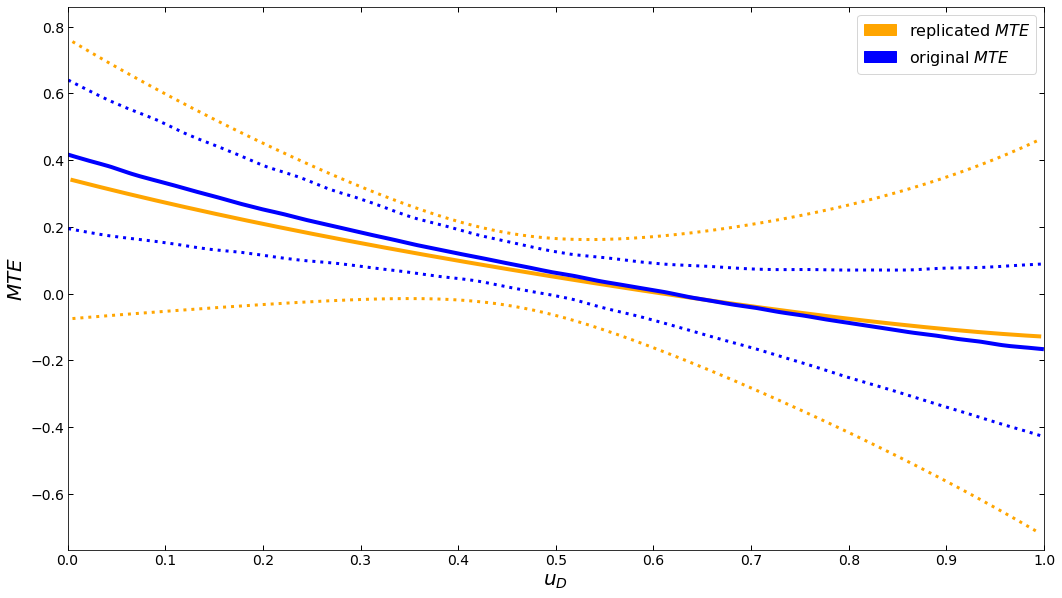

In [6]:
mte, quantiles = plot_mte_carneiro(rslt, "semipar/files/replication_carneiro.yml", nbootstraps=250)

People with the highest returns to education (those who have low unobserved resistance $u_D$
) are more likely to go to college. Note that the returns vary considerably with $u_D$
. Low $u_D$ students have returns of up to 40% per year of college, whereas high $u_D$
 people, who would loose from attending college, have returns of approximately - 15%.
    
    
The magnitude of total heterogeneity is probably even higher, as the MTE depicts the average gain of 
college attendance at the mean values of X, <br> i.e. $\bar{x} (\beta_1 - \beta_0)$. 
Conditioning instead on $X (\beta_1 - \beta_0)$, 
we observe returns as high as 64% and as low as -57%.

## 3) Estimating the Returns to Higher Education in Germany

We now turn to the analysis of the returns to schooling in Germany. I study a sample of 451 indiviudals without migration background, including men and women born between 1950 and 1971 in West Germany. As mentioned above, the common support assumption is critical for the identification of the MTE via Local Instrumental Variables (LIV). I plot it below.

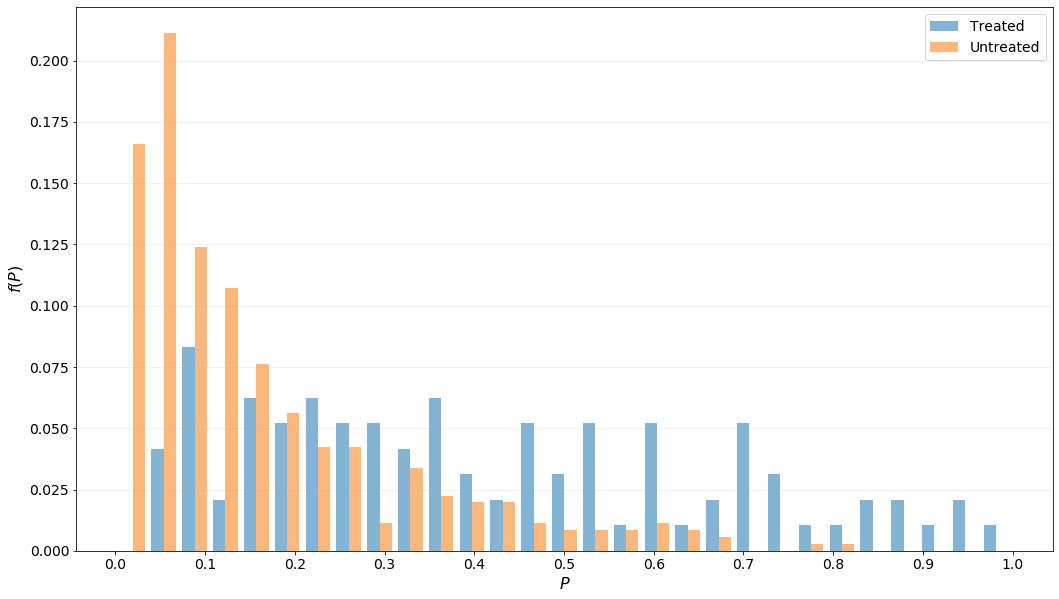

In [7]:
plot_common_support("semipar/files/soep_analysis.yml", nbins=29, fs=16) 

Common support is defined as the region where the support of $P(Z)$ given $D=1$ and the support of $P(Z)$ given $D=0$ overlap. It is not the simply the range from the smallest propensity observed in the treated sample to the maximum propensity observed in the untreated sample, as their marginal supports might not overlap in between. This would become evident by "holes" and "dents" in the histograms above. Although we observe positive frequencies for $P(Z)$ up to 0.83 in the untreated subpopulation, the continuous overlap of positive frequencies stops at 0.69 

We now turn to the estimation of the semiparametric MTE using LIV.

                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                  451
Model:                         Probit   Df Residuals:                      424
Method:                           MLE   Df Model:                           26
Date:                Fri, 17 Jan 2020   Pseudo R-squ.:                  0.2342
Time:                        03:13:43   Log-Likelihood:                -178.80
converged:                       True   LL-Null:                       -233.49
Covariance Type:            nonrobust   LLR p-value:                 3.373e-12
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2315.3468   1157.704      2.000      0.046      46.288    4584.405
sex                      -0.3567      0.158     -2.256      0.024      -0.667      -0.047
iq      

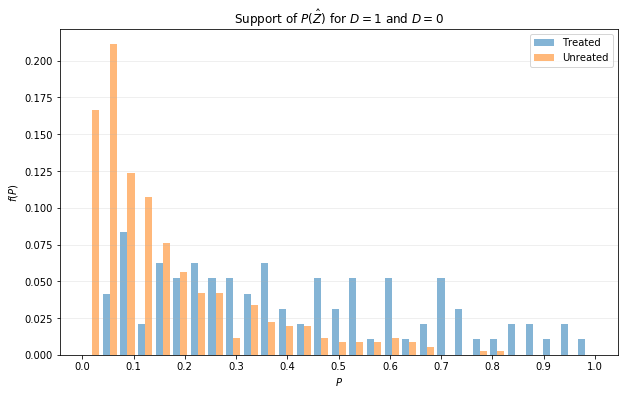

In [8]:
rslt = fit("semipar/files/soep_analysis.yml", semipar=True)

Note that *grmpy-semipar* plots the MTE over almost the full unit interval although common support lies only between $[0.040, 0.690]$. The reason for this is that we set *p_range* in the initialization file to $[0.005, 0.995]$. *grmpy-semipar* utilizes the information within the common support to extrapolate the MTE for points outside the common support, as specified in *p_range*. Technically speaking, however, interpretations of the MTE are only valid within the actual common support of $[0.040, 0.690]$, for which the MTE is identified.

### 3.1 Local Instrumental Variables

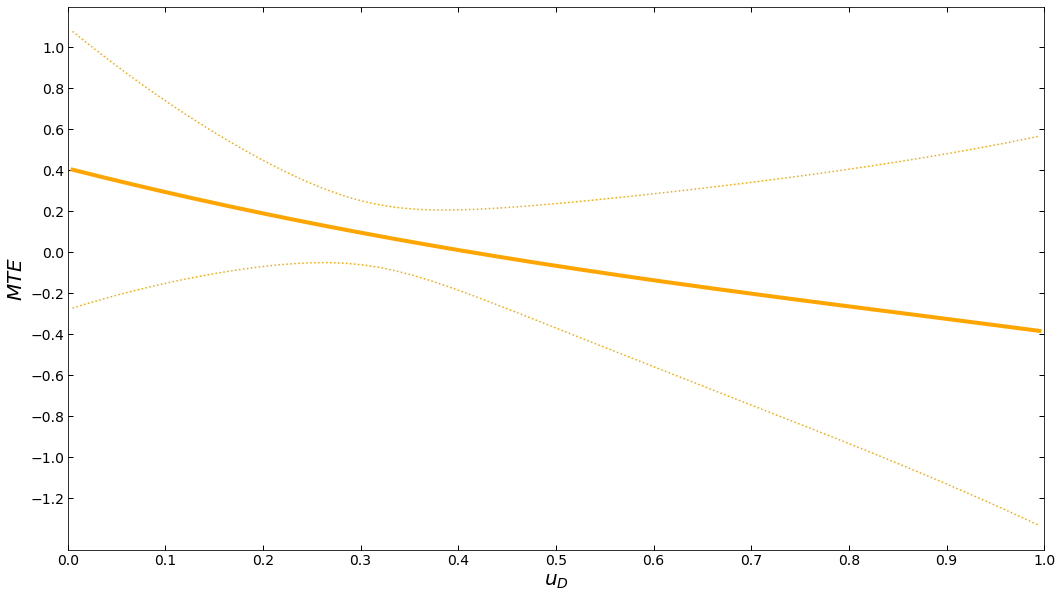

In [9]:
mte, quantiles = plot_mte_soep(rslt, "semipar/files/soep_analysis.yml", nbootstraps=250)

Similar to the US-American case presented above, returns to education in Germany also vary considerably with $u_D$. People with the highest returns to education (those who have low unobserved resistance $u_D$ ) are more likely to attend university. Low $u_D$ students have returns of up to $40\%$ per year of university, whereas high $u_D$ people, who would loose from pursuing/completing a post-secondary degree, have returns of approximately $-0.38\%$. 

The total degree of heterogeneity is probably even higher, as the MTE depicts the average gain of one year of post-secondary education at the mean values of $X$, i.e. $\bar{x} (\beta_1 - \beta_0)$. Accounting for the variation in $X$, returns can be as low as $-94\%$ and as high as $72\%$. 

The dotted lines depict 90 percent confidence bands based on 250 bootstrap replications. As the bootstrap method is sensitive to small data sets, it produces fairly large standard errors.

### 3.2 Parametric Normal Model

In addition, I use the current functionality of [*grmpy*](https://grmpy.readthedocs.io/en/develop/) to estimate the returns to education in Germany based on a parametric model. Non-parametric techniques to estimate $K(P)$ are not required, as the unobservables are assumed to have a known functional form, i.e., joint normality. 
Note that this condition is stronger than the assumption of independence and additive separability in the LIV framework.

In [10]:
rslt = fit("semipar/files/soep_analysis.yml", semipar=False)

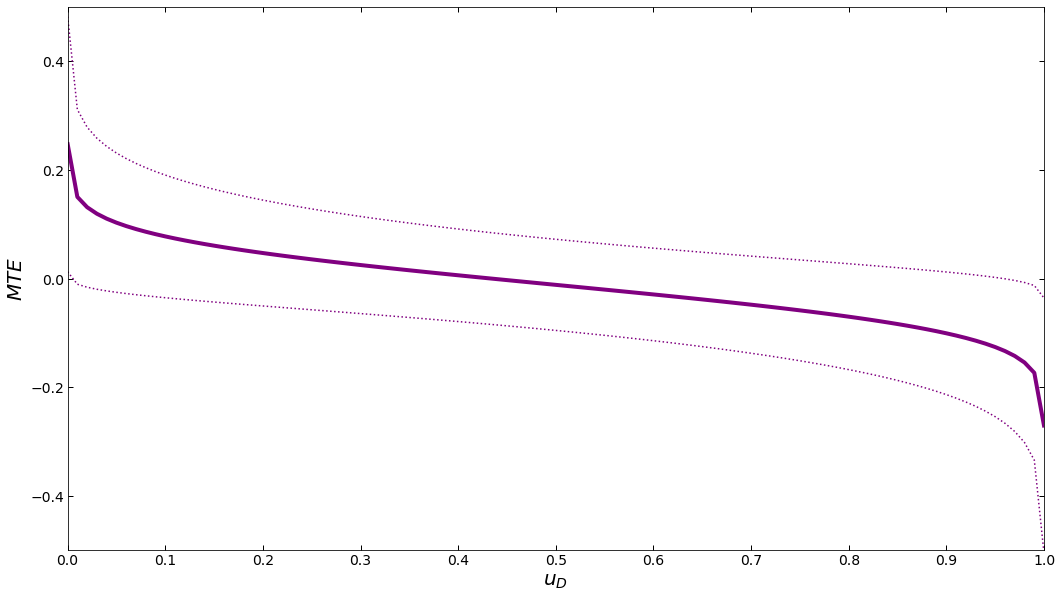

In [11]:
mte = plot_mte_par(rslt, "semipar/files/soep_analysis.yml")

Observe that parametric MTE is flatter than the semiparametric MTE above. This is in line Carneir et al. (2011) who find that the parametric MTE underestimates the returns to schooling in the US.